In [2]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [3]:
#import csv
df_motion = pd.read_csv('clustering_columns.csv')

In [4]:
from sklearn.preprocessing import StandardScaler

#standardize the variables before conducting PCA
scaler = StandardScaler()
scaler.fit(df_motion)
df_motion_scaled = scaler.transform(df_motion)

In [5]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

In [6]:
pca.fit(df_motion_scaled)

PCA(random_state=42)

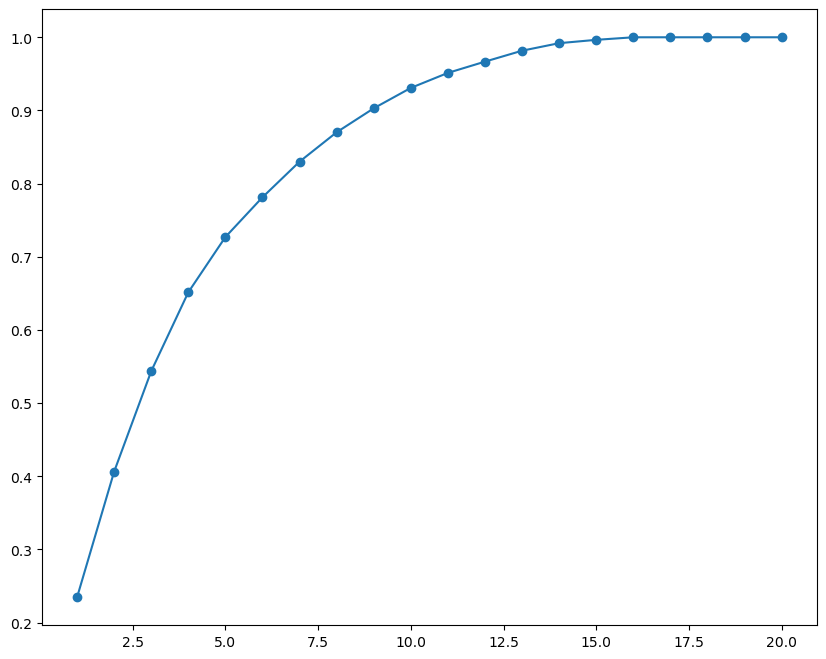

In [7]:
#find explained variance at different n values
plt.figure(figsize = (10,8))
plt.plot(range(1,21), pca.explained_variance_ratio_.cumsum(), marker = 'o')

In [8]:
#to preserve ~80% of variance, set n_components=5
pca = PCA(n_components=6, random_state=42)
pca.fit(df_motion_scaled)

PCA(n_components=6, random_state=42)

In [9]:
#apply PCA to data
x_pca = pca.transform(df_motion_scaled)

  0%|          | 0/50 [00:00<?, ?it/s]  File "C:\Users\etien\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\etien\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


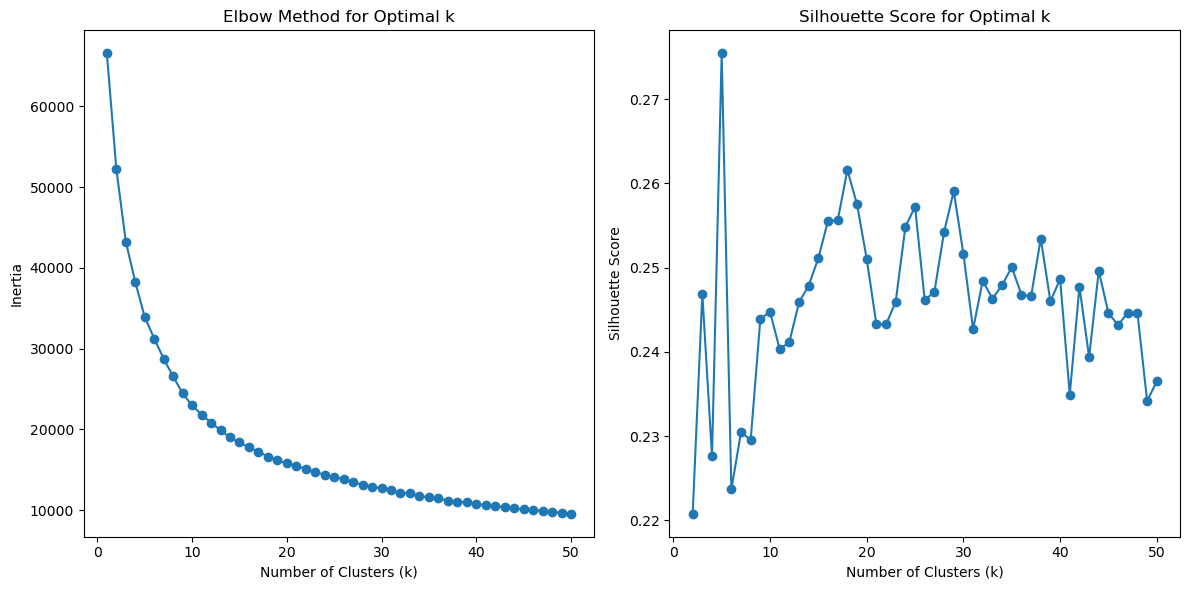

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#define a range of k values to try
k_range = range(1, 51)  # Trying k values from 1 to 50

#for storing inertia and silhouette scores
inertia = []
sil_scores = []

#loop through each value of k
for k in tqdm(k_range):
    #perform KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(x_pca)  # Use your PCA-transformed data (x_pca)

    #compute inertia for Elbow Method
    inertia.append(kmeans.inertia_)

    #compute silhouette score
    if k > 1: 
        sil_score = silhouette_score(x_pca, labels)
        sil_scores.append(sil_score)
    else:
        sil_scores.append(-1)



plt.figure(figsize=(12, 6))

#plot the Elbow Method
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

#plot for Silhouette Scores 
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], sil_scores[1:], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()


In [11]:
#use n=24
cluster_num = 24
kmeans = KMeans(n_clusters=cluster_num, random_state=42) 
labels = kmeans.fit_predict(x_pca)

In [12]:
#set labels as a column in original df
df_player_play_motion = pd.read_csv('df_player_play_motion.csv')
df_player_play_motion['motion_label'] = kmeans.labels_

In [13]:
#create a dictionary to hold DataFrames for each unique motion_label
motion_label_dfs = {label: df_player_play_motion[df_player_play_motion['motion_label'] == label]
                     for label in df_player_play_motion['motion_label'].unique()}

In [14]:
#get the row size of every df in motion_label_dfs
row_sizes = {label: df.shape[0] for label, df in motion_label_dfs.items()}
#print the row sizes in numerical order, one per line
for label, size in sorted(row_sizes.items(), key=lambda item: item[1]):
    print(f'Motion Label: {label}, Row Size: {size}')

Motion Label: 21, Row Size: 59
Motion Label: 18, Row Size: 62
Motion Label: 23, Row Size: 77
Motion Label: 20, Row Size: 80
Motion Label: 9, Row Size: 89
Motion Label: 15, Row Size: 116
Motion Label: 7, Row Size: 119
Motion Label: 6, Row Size: 127
Motion Label: 13, Row Size: 133
Motion Label: 10, Row Size: 135
Motion Label: 8, Row Size: 135
Motion Label: 3, Row Size: 162
Motion Label: 11, Row Size: 165
Motion Label: 17, Row Size: 168
Motion Label: 4, Row Size: 170
Motion Label: 19, Row Size: 196
Motion Label: 14, Row Size: 199
Motion Label: 0, Row Size: 218
Motion Label: 22, Row Size: 220
Motion Label: 1, Row Size: 220
Motion Label: 16, Row Size: 243
Motion Label: 2, Row Size: 365
Motion Label: 5, Row Size: 465
Motion Label: 12, Row Size: 561


In [15]:
#dictionary with description of each category
motion_dict = {
    12:'Motion next to opposite side tackle',
    5:'Slot player cuts in front of the ball',
    2:'Motion to other side of line as a wideout',
    16:'Wideout cuts back towards the snap',
    1:'RB motions to other side of QB',
    22:'Slight motion next to Tackle',
    0:'Wideout motions closer to line',
    14:'Slot player moves towards the snap',
    19:'Wideout motions next to tackle',
    4:'Closer wideout motions to backfield', 
    17:'RB small motion forward',
    11:'Player slightly motions next to tackle', 
    3:'Wideout motions past ball then cuts back',
    8:'RB goes forward then returns',
    10:'RB motion in backfield',
    13:'Wideout motions further outside',
    6:'Backfield motions to closer wideout (same side)', 
    7:'Backfield motions to closer wideout (opposite side)',
    15:'Wideout motions to backfield',
    9:'Wideout motions to slot',
    20:'Wideout moves back but returns to inital position',
    23:'Player behind tackle moves to wideout', 
    18:'Backfield motions to farther wideout (same side)',
    21:'Backfield motions to farther wideout (opposite side)'
}

In [16]:
#compute the average for the numeric columns for a category
columns_to_average = [
    'shiftSinceLineset', 'motionSinceLineset', 'snap_motion_gap', 
    'init_rel_y_dis', 'end_rel_y_dis', 'overall_y_change', 
    'init_rel_x_dis', 'end_rel_x_dis', 'overall_x_change', 
    'motion_s_avg', 'frames_in_motion', 'swapped_side',
    'y_dis_travel_pos', 'y_dis_travel_neg','swapped_y_dir',
    'x_dis_travel_pos', 'x_dis_travel_neg',
    'inMotionAtBallSnap','init_tackle_dis','end_tackle_dis'
]

catgeory_to_avg = 0
motion_label_dfs[catgeory_to_avg][columns_to_average].mean()

shiftSinceLineset        0.018349
motionSinceLineset       1.000000
snap_motion_gap          0.316514
init_rel_y_dis        1655.940367
end_rel_y_dis         1173.114679
overall_y_change       482.825688
init_rel_x_dis        -192.188073
end_rel_x_dis         -137.715596
overall_x_change       -54.472477
motion_s_avg           207.508494
frames_in_motion        23.366972
swapped_side             0.000000
y_dis_travel_pos        14.357798
y_dis_travel_neg       494.770642
swapped_y_dir            0.110092
x_dis_travel_pos        34.522936
x_dis_travel_neg        33.128440
inMotionAtBallSnap       0.931193
init_tackle_dis       1366.344037
end_tackle_dis         883.715596
dtype: float64

In [17]:
#Export labels for every motion
df_player_play_motion.to_csv('player_play_motion_labels.csv',index=False)